In [8]:
import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K
from keras.models import model_from_json

from pathlib import Path

### Try to visualize convolutional filters. 

Code that I copied from the Keras Documentation.  Complete credit to: https://keras.io/examples/conv_filter_visualization/

In [70]:
def normalize(x):
    """utility function to normalize a tensor.

    # Arguments
        x: An input tensor.

    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.

    # Arguments
        x: A numpy-array representing the generated image.

    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.

    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.

    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.

    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.

        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.

        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.

        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        reports_path = Path('../reports/figures/')
        reports_path.mkdir(parents=True, exist_ok=True)
        
        file_name = reports_path / 'model_{0:}_{1:}x{1:}.png'
        save_img(str(file_name).format(layer_name, n), stitched_filters)
        print(r'Saved image to {0}'.format(str(file_name)))

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    print(layer_dict)
    
    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, filter_upper):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

Loading in the previously trained model (this should be .json). 

Input <b>Model Name</b>

In [65]:
model_name = 'third'

model_dir = Path("../models/" + model_name)

In [66]:
with open(model_dir / (model_name + '.json'), 'r') as f:
    model_json = f.read()
model = model_from_json(model_json)
# load weights into new model
model.load_weights(model_dir / (model_name + '.h5'))

Visualize the layer. 

In [71]:
# the name of the layer we want to visualize
LAYER_NAME = 'conv2d_2'

model.summary()

# example function call
visualize_layer(model, LAYER_NAME)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 48)        13872     
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 48)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 48)        20784     
__________

### Looking at some out of sample images. 

In [72]:
import matplotlib.pyplot as plt

from pathlib import Path
from skimage import color, io

import os

5.0

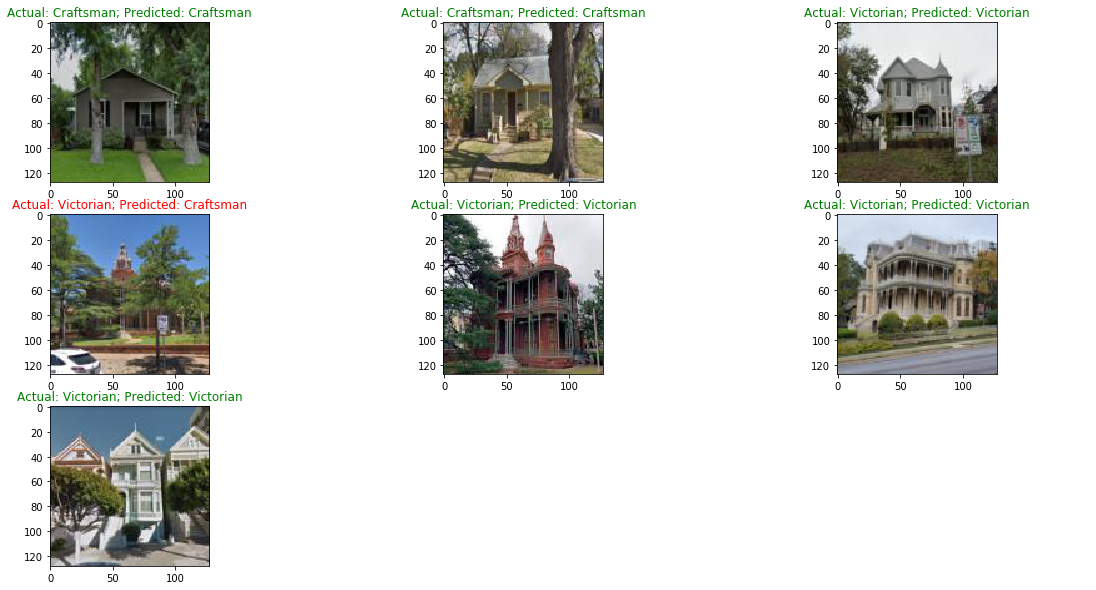

In [100]:
oos_test_dir = Path(r'..\data\processed\Testing Images')

oos_preds = []
n_files = len(os.listdir(oos_test_dir))

n_col = 3
n_row = int(np.ceil(n_files/n_col))

fig, axes = plt.subplots(figsize=(20,10), nrows=n_row, ncols=n_col)
ax = axes.ravel()

i = 0
for file in os.listdir(oos_test_dir):
    if 'victorian' in file:
        label = 1
    else:
        label = 0
        
    file_path = oos_test_dir / file
    im = io.imread(oos_test_dir / file).reshape(128, 128, 3)
    im = np.expand_dims(im, axis=0)/255.
    pred = model.predict(im)
    rounded_pred = np.round(pred[0][0])
    
    if rounded_pred == label:
        correct = True
    else:
        correct = False

    title = 'Actual: Victorian; ' if label == 1 else 'Actual: Craftsman; '
    title += 'Predicted: Victorian' if rounded_pred == 1 else 'Predicted: Craftsman'
    
    ax[i].imshow(im[0,])
    ax[i].set_title(title, color = 'green' if correct else 'red')
    i += 1
    
# Turn off extra rows
for j in range(i, n_col*n_row):
    ax[j].axis('off')
    
plt.show()

fig.savefig('../reports/figures/out_of_sample_predictions.png')

In [ ]:
ax.set_facecolor

### Calculating standard metrics on the test data. 

In [26]:
test_dir = Path(r'..\data\processed\test')
labels = {'Victorian': 1, 'Craftsman': 0}

In [27]:
preds = {}

for label_str, label_int in labels.items():
    in_dir = test_dir / label_str
    preds[label_str] = []
    for f in os.listdir(in_dir):
        im = io.imread(in_dir / f).reshape(128, 128, 3)
        im = np.expand_dims(im, axis=0)/255.
        pred = model.predict(im)
        preds[label_str].append(pred[0][0])

Other metrics to calculated. 

 - Precision
     - True Positive / Predicted Condition Positive
     - <b> What percentage of the labeled Victorian Homes are actually Victorian? </b>
         - Risk: With a low Precision, I could be innacurately labeling homes as Victorian, and I may end up buying a Craftsman. 
     - Also known as Positive Predictive Value
 - Recall
     - True Positive / Condition Positive
     - <b> How many of the Victorian Homes was I able to accurately label? </b>
         - Risk: With a low Recall, I may not be labeling enough homes as Victorian.  I might miss out on a Victorian Home.  
     - Also known as True Positive Rate or Sensitivity
 - Specificity
     - True Negative / Condition Negative
     - <b> How many of the Craftsman Homes was I able to accurately label  </b>
     - Partner to Recall
         - Risk: With a low Specificity, I may not be labeling enough homes as Craftsman.  I might miss out on a Craftsman Home.  
     - Also known as True Negative Rate or Selectivity
 - F1 Score
     - Harmonic Mean of Precision and Recall.  
     - Basically chains together the ideas of <b>Picking Out Positives (Recall)</b> and <b>Making Sure Positive Are Truly Positive (Precision)</b>
     - $ 2*((Precision*Recall)/(Precision + Recall)) $

In [28]:
thresholds = np.linspace(0, 1, 401)
roc_metrics = {}
for t in thresholds:
    tpr = np.sum(preds['Victorian'] > t)/len(preds['Victorian'])
    fpr = np.sum(preds['Craftsman'] > t)/len(preds['Craftsman'])
    
    tnr = np.sum(preds['Craftsman'] < t)/len(preds['Craftsman'])
    fnr = np.sum(preds['Victorian'] < t)/len(preds['Victorian'])
    
    roc_metrics[t] = {'tpr': tpr, 'fpr': fpr, 'tnr': tnr, 'fnr': fnr}

In [29]:
import pandas as pd

In [30]:
roc_metrics_df = pd.DataFrame(roc_metrics).T
roc_metrics_df = roc_metrics_df.sort_index()

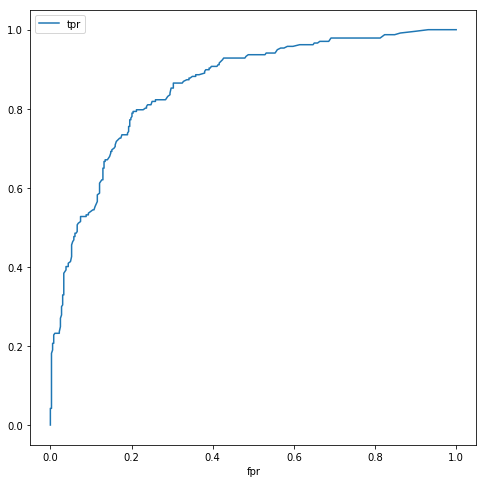

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

roc_metrics_df.plot(x='fpr', y='tpr', ax=ax, label='tpr')

In [43]:
cum_sum = 0.0

last_idx = 0.0
last_tpr = 0.0
i = 0
d_tprs = []
for idx, row in roc_metrics_df.iterrows():
    if i != 0:
        assert(idx > last_idx)
        
    tpr = row['tpr']
    
    # Compute integral
    step = idx - last_idx
    cum_sum += step*tpr
    
    if i != 0:
        # Compute derivative of TPR
        d_tpr = (last_tpr - tpr)/step
    else:
        d_tpr = 0
    
    d_tprs.append(d_tpr)
    last_idx = idx
    last_tpr = tpr
    i += 1
print(f'AUC is {cum_sum}')

AUC is 0.5856223628691982


### Visualizing activations in response to certain images. 

In [44]:
for i in enumerate(model.layers):
    print(i)

(0, <keras.layers.convolutional.Conv2D object at 0x00000000176E4208>)
(1, <keras.layers.core.Activation object at 0x00000000176E43C8>)
(2, <keras.layers.pooling.MaxPooling2D object at 0x00000000176E4470>)
(3, <keras.layers.convolutional.Conv2D object at 0x0000000017708940>)
(4, <keras.layers.core.Activation object at 0x00000000176E4588>)
(5, <keras.layers.pooling.MaxPooling2D object at 0x0000000004E88400>)
(6, <keras.layers.convolutional.Conv2D object at 0x0000000017708F98>)
(7, <keras.layers.core.Activation object at 0x0000000004E9BEF0>)
(8, <keras.layers.pooling.MaxPooling2D object at 0x0000000004E9BA90>)
(9, <keras.layers.core.Flatten object at 0x0000000004EB7F60>)
(10, <keras.layers.core.Dense object at 0x0000000004EB7A58>)
(11, <keras.layers.core.Activation object at 0x0000000004ED0E80>)
(12, <keras.layers.core.Dropout object at 0x0000000004ED0860>)
(13, <keras.layers.core.Dense object at 0x0000000004ED0E10>)
(14, <keras.layers.core.Activation object at 0x0000000004F06FD0>)


In [114]:
model.layers[3:4]

In [115]:
layer_outputs = [layer.output for layer in model.layers[3:4]]
print(layer_outputs)

[<tf.Tensor 'conv2d_2_2/BiasAdd:0' shape=(?, 61, 61, 48) dtype=float32>]


Credit to: https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

In [116]:
from keras.models import Model
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [117]:
test_f = Path(r'..\data\processed\Testing Images\craftsman1.PNG128x128.jpg')

im = io.imread(test_f).reshape(128, 128, 3)
im = np.expand_dims(im, axis=0)/255.
activations = activation_model.predict(im)

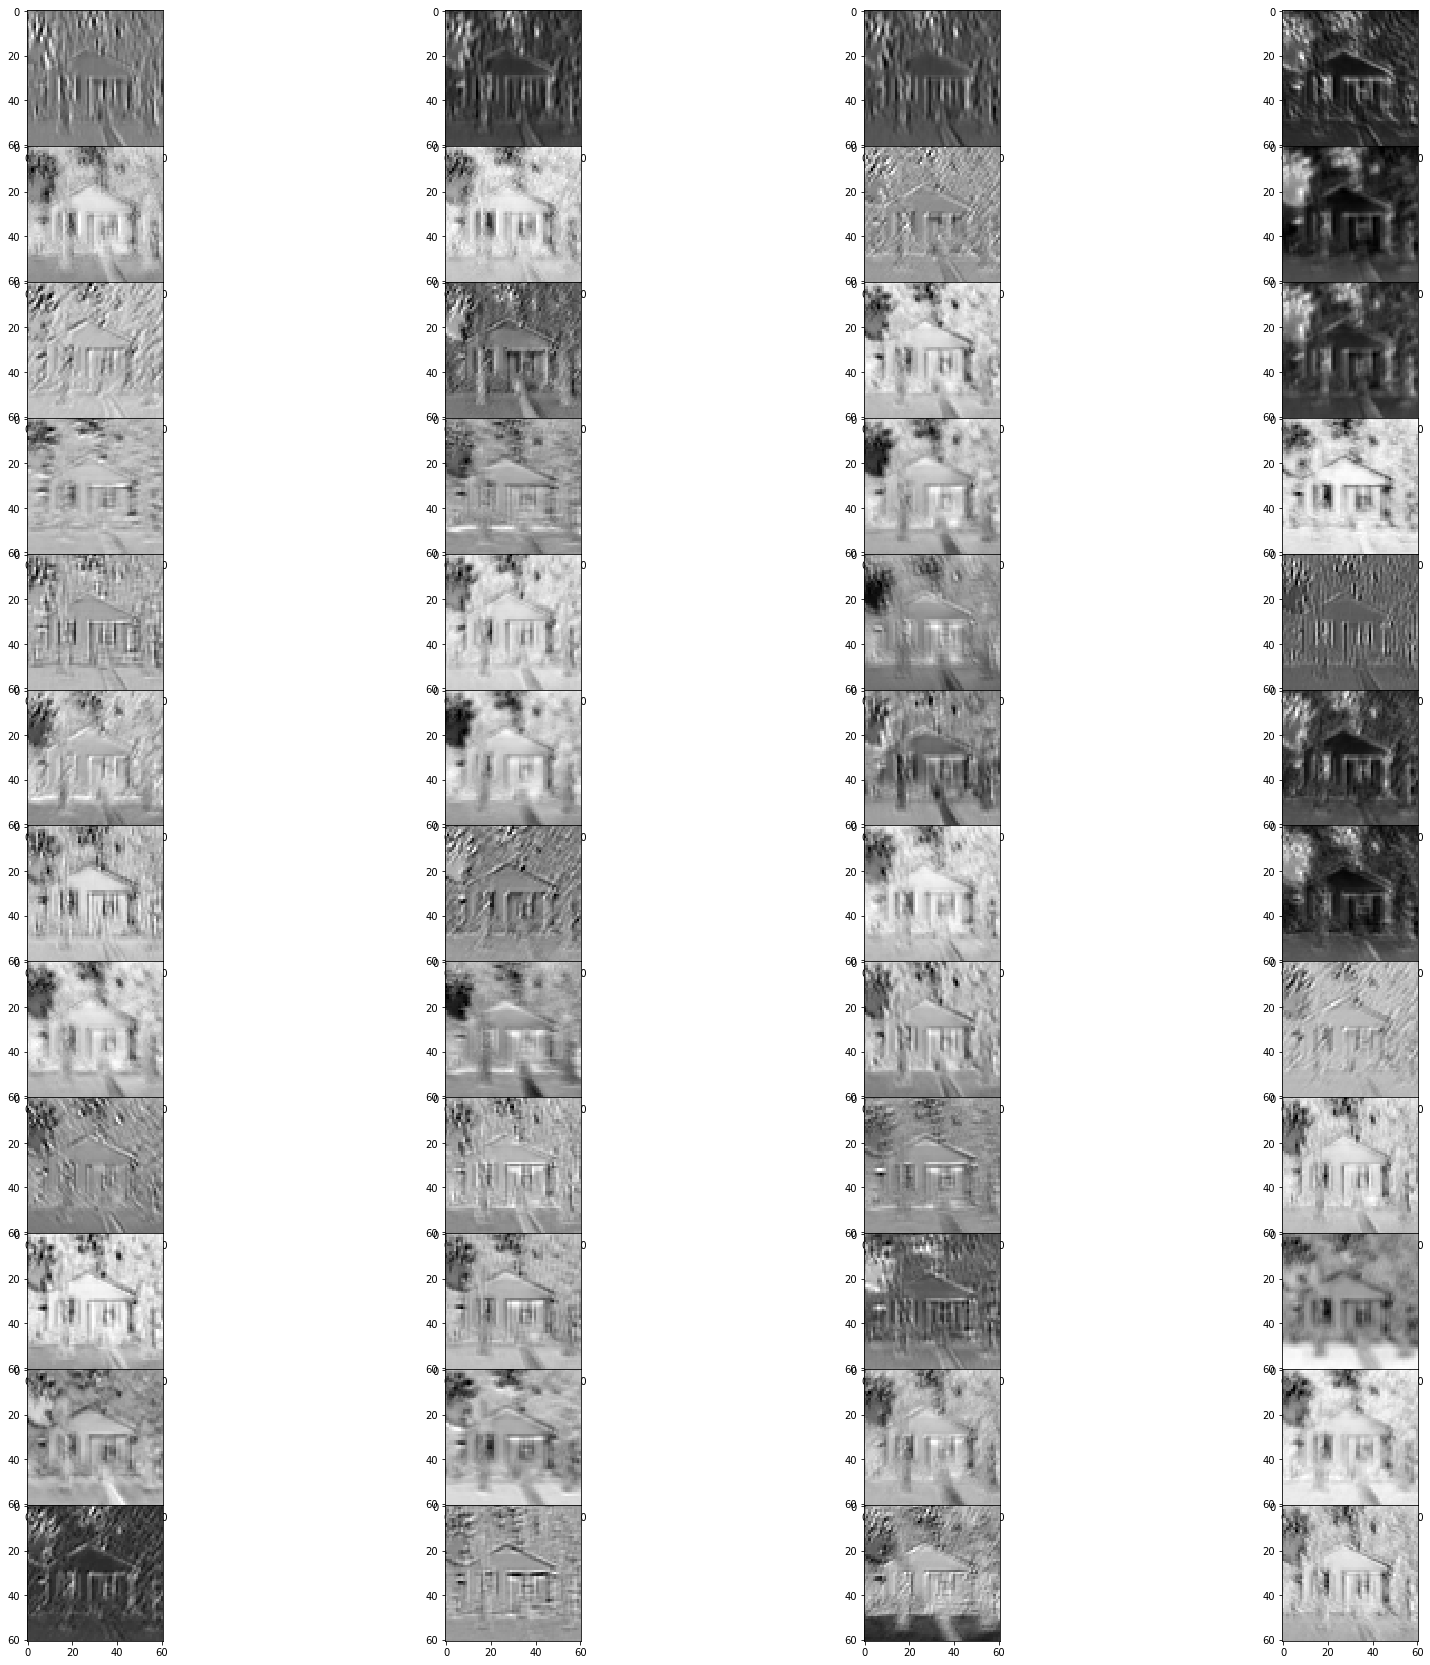

In [118]:
n_col = 4

for layer in activations:
    n_row = int(layer.shape[2]/n_col)
    fig, axes = plt.subplots(figsize=(30,30), nrows=n_row, ncols=n_col)
    fig.subplots_adjust(wspace=0, hspace=0)
    ax = axes.ravel()

    for i in range(layer.shape[2]):
        ax[i].imshow(layer[:,:,i], cmap='gray')
    plt.show()
    fig.savefig('../reports/figures/conv_layer_2.png')